In [1]:
# Author: Lee Yat Shun, Jasper
# Copyright (c) 2023 Lee Yat Shun, Jasper. All rights reserved.

In [2]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from caviar import CaviarModel
from backtesting import backtest
from var_tests import binomial_test, kupiec_pof_test, christoffersen_test

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_excel('../data/SPY.xlsx')
df.columns = df.iloc[5].values
df = df.iloc[6:].iloc[::-1].reset_index(drop=True)
df['Log Return'] = df.PX_LAST.apply(lambda x: np.log(x)).diff()
df = df.set_index('Date')
df.head()

,PX_LAST,Change,% Change,PX_OPEN,Change,% Change,PX_HIGH,Change,% Change,PX_LOW,Change,% Change,Log Return
Date,,,,,,,,,,,,,
1993-01-29,25.2238,NaN,NaN,25.2417,NaN,NaN,25.2417,NaN,NaN,25.1161,NaN,NaN,NaN
1993-02-01,25.4032,NaN,NaN,25.2417,NaN,NaN,25.4032,NaN,NaN,25.2417,NaN,NaN,0.007087
1993-02-02,25.457,NaN,NaN,25.3852,NaN,NaN,25.4749,NaN,NaN,25.3314,NaN,NaN,0.002116
1993-02-03,25.7261,NaN,NaN,25.4929,NaN,NaN,25.744,NaN,NaN,25.4749,NaN,NaN,0.010515
1993-02-04,25.8337,NaN,NaN,25.8158,NaN,NaN,25.8876,NaN,NaN,25.762,NaN,NaN,0.004174


In [5]:
returns = df['Log Return'].dropna()
low_open_log_difference = (df['PX_LOW'].apply(lambda x: np.log(x)) - df['PX_OPEN'].apply(lambda x: np.log(x))).dropna()

## Numeric

In [6]:
in_samples = returns[2000:-2000] * 100
out_of_samples = returns[-2000:] * 100

In [7]:
# initiate parameter
quantile = 0.05 # 5% VAR

In [8]:
# fitting process
caviar_model = CaviarModel(quantile, model='asymmetric', method='mle')
caviar_model.fit(in_samples)

      fun: -3840.93327842694
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.80392669, -27.55673449,  96.44122608, -11.94630386,
        14.96150618])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 498
      nit: 41
     njev: 83
   status: 0
  success: True
        x: array([ 0.12485068, -0.03839757,  0.93388229, -0.00671056,  0.19963131])
Final loss: 0.12480833513082279
Time taken(s): 3.61


In [9]:
print('S.E. of beta:', caviar_model.beta_standard_errors)
print('pval of beta:', caviar_model.beta_pvals)

S.E. of beta: [0.01166731 0.02395543 0.03891324 0.07773683]
pval of beta: [0.00049909 0.         0.4315422  0.00511376]


### Backtesting on the out of samples

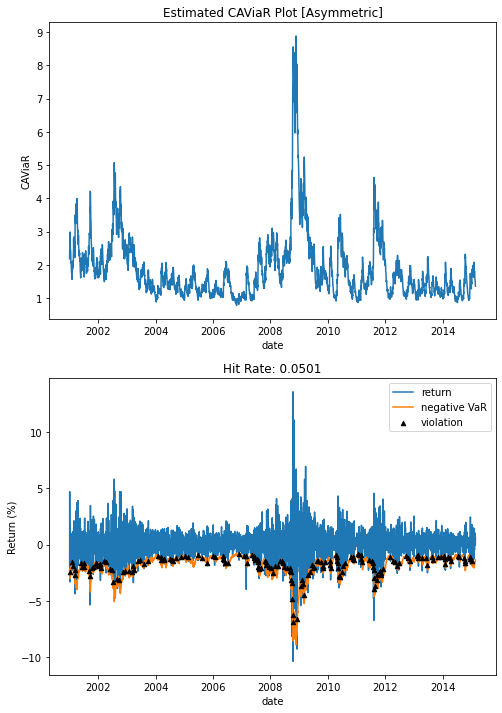

In [10]:
# in sample
caviar_model.plot_caviar(in_samples)

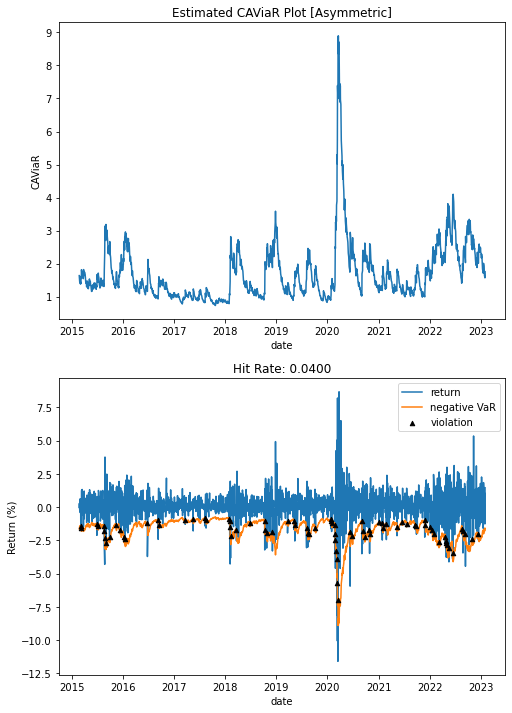

In [11]:
# out of sample
caviar_model.plot_caviar(out_of_samples)

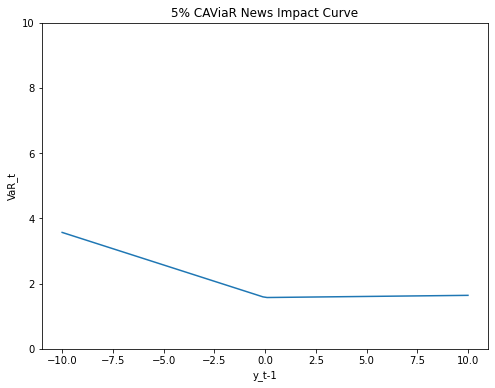

In [12]:
caviar_model.plot_news_impact_curve(VaR=-1.645)

In [13]:
# RQ loss
print(caviar_model.obj(caviar_model.beta, in_samples, caviar_model.quantile, caviar_model.caviar))
print(caviar_model.obj(caviar_model.beta, out_of_samples, caviar_model.quantile, caviar_model.caviar))

0.12480833513082279
0.12635526330912736


### VaR Test

In [14]:
in_VaR = caviar_model.predict(in_samples)

In [15]:
out_VaR = caviar_model.predict(out_of_samples)

In [ ]:
(out_of_samples[1:] < out_VaR[:-1]).value_counts(normalize=True)

In [16]:
# The null hypothesis states that the current VaR violations are uncorrelated with past violations.

print(caviar_model.dq_test(in_samples, 'in'))
print(caviar_model.dq_test(out_of_samples, 'out'))

0.1966984026040469
0.9997042229435632


In [17]:
# H0: the obs ~ binomial(p)

print(binomial_test(in_samples, in_VaR, caviar_model.quantile))
print(binomial_test(out_of_samples, out_VaR, caviar_model.quantile))

0.96930383635541
0.04001082220695236


In [18]:
# H0: the observed failure rate is equal to the failure rate suggested by the confidence interval.

print(kupiec_pof_test(in_samples, in_VaR, caviar_model.quantile))
print(kupiec_pof_test(out_of_samples, out_VaR, caviar_model.quantile))

1.0
1.0


In [19]:
# null hypothesis: the observations are independent of each other

print(christoffersen_test(in_samples, in_VaR))
print(christoffersen_test(out_of_samples, out_VaR))

0.2569369425074938
0.8575427441112737


### Mean reversion property?

In [51]:
# the_following_day = out_of_samples[1:][out_of_samples[1:] < out_VaR[:-1]].index + pd.Timedelta(1, unit='D')

# equivalently
the_following_day = np.array(range(1999))[out_of_samples[1:] < out_VaR[:-1]] + 1

In [56]:
out_of_samples[1:].iloc[the_following_day].describe()

count    81.000000
mean      0.260150
std       1.831131
min      -4.301879
25%      -0.516612
50%       0.209146
75%       1.099771
max       8.202780
Name: Log Return, dtype: float64

In [58]:
(out_of_samples[1:].iloc[the_following_day]/100 + 1).cumprod()

Date
2015-03-11    0.997656
2015-06-30    0.999742
2015-07-09    1.001549
2015-08-21    0.970937
2015-08-24    0.929169
                ...   
2022-08-23    1.249104
2022-08-29    1.240817
2022-09-14    1.245543
2022-11-03    1.232651
2022-12-16    1.218013
Name: Log Return, Length: 81, dtype: float64

<AxesSubplot:ylabel='Frequency'>

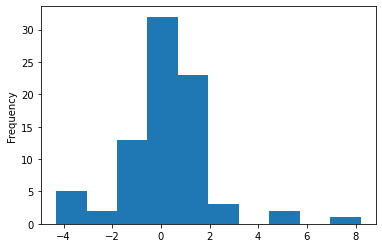

In [55]:
out_of_samples[1:].iloc[the_following_day].plot.hist()

### Backtesting

In [20]:
out_low_open_log_difference = low_open_log_difference.loc[out_of_samples.index]
(out_low_open_log_difference * 100 < out_VaR).value_counts(normalize=True)

False    0.9485
True     0.0515
dtype: float64

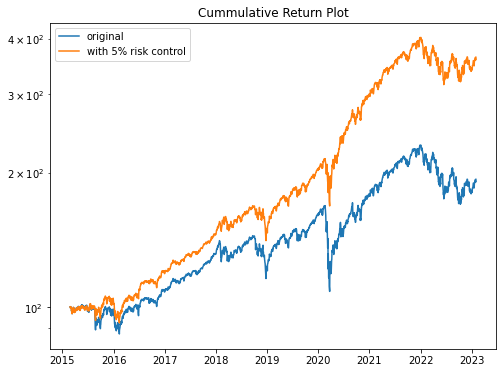

In [21]:
# with 0.2% transaction cost

backtest(out_of_samples, out_low_open_log_difference, out_VaR, caviar_model.quantile, ntl=100, penalty=0.002)

### Forecast

In [22]:
caviar_model.forecast(out_of_samples[-1], out_VaR[-1])

-1.6877845130478544